In [1]:
import time
from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the data
df = pd.read_csv('Data/train_essays/train_essays.csv')

# Display the data
df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [4]:
# Load the data
df_prompts = pd.read_csv('Data/train_prompts.csv')

# Display the data
df_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords and lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    
    return words

# Initialize tqdm for pandas
tqdm.pandas()

# Define a function to apply to the DataFrame
def preprocess_df(df):
    # Apply the preprocess_text function to the 'text' column with a progress bar
    return df['text'].progress_apply(preprocess_text)

# Start the timer
start_time = time.time()

# Preprocess the text
df['text'] = preprocess_df(df)

# Train a Word2Vec model
model = Word2Vec(df['text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Convert words into numerical representations
df['text'] = df['text'].apply(lambda text: [model.wv[word] for word in text])

# Pad the sequences
df['text'] = pad_sequences(df['text']).tolist()

# Convert the list of sequences into a numpy array
X = np.array(df['text'].tolist())

#  y is target variable
y = np.array(df['generated'].tolist())

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")

100%|██████████| 1378/1378 [01:43<00:00, 13.37it/s]


Elapsed time: 00:01:56.86


This code is performing several steps to preprocess text data and prepare it for a machine learning model. Here's a step-by-step explanation:

1. **Initialize the lemmatizer**: The `WordNetLemmatizer` from the `nltk` library is used to reduce words to their base or root form (e.g., "running" to "run").

2. **Define the preprocess_text function**: This function takes a string of text, tokenizes it into individual words, removes stopwords (common words like "and", "the", "is", etc.), and lemmatizes the remaining words.

3. **Initialize tqdm for pandas**: `tqdm` is a library that provides a fast, extensible progress bar. The `tqdm.pandas()` function modifies pandas to include progress bars when applying functions across a DataFrame.

4. **Preprocess the text**: The `preprocess_text` function is applied to the 'text' column of the DataFrame, transforming the raw text into a list of preprocessed words.

5. **Train a Word2Vec model**: A Word2Vec model is trained on the preprocessed text. Word2Vec is a technique for natural language processing where words are mapped to vectors of real numbers. It represents words in a coordinate system where related words, based on a corpus of text, are placed closer together.

6. **Convert words into numerical representations**: The words in the 'text' column are replaced with their corresponding vector representations from the trained Word2Vec model.

7. **Pad the sequences**: The sequences are padded to ensure they all have the same length. This is typically required for neural networks which expect input tensors to have the same shape.

8. **Convert the list of sequences into a numpy array**: The preprocessed and padded text data is converted into a numpy array, which can be used as input to a machine learning model.

9. **Convert the target variable into a numpy array**: The target variable is also converted into a numpy array.

10. **Print the elapsed time**: The time taken to execute the above steps is calculated and printed. This is useful for performance analysis.

This code is preparing the data for a machine learning model that can handle sequence data, such as a Recurrent Neural Network (RNN).

In [6]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(f"Training data shape: {X_train.shape[0]}")
print(f"Test data shape: {X_test.shape[0]}")
print(f"Training labels shape: {y_train.shape[0]}")
print(f"Test labels shape: {y_test.shape[0]}")

Training data shape: 1102
Test data shape: 276
Training labels shape: 1102
Test labels shape: 276


In [8]:
# Define the size of the vocabulary, the embedding dimension, and the maximum sequence length
vocab_size = len(model.wv.key_to_index) + 1  # Adding 1 because of reserved 0 index for padding
embedding_dim = 100  # This should match the size of the Word2Vec vectors 🙂
max_seq_length = len(max(df['text'], key=len))

# Build the RNN model
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, input_shape=(max_seq_length, embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
35/35 [==============================] - 9s 202ms/step - loss: 0.0818 - accuracy: 0.9782 - val_loss: 0.0278 - val_accuracy: 0.9964
Epoch 2/10
35/35 [==============================] - 6s 173ms/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.0282 - val_accuracy: 0.9964
Epoch 3/10
35/35 [==============================] - 6s 172ms/step - loss: 0.0124 - accuracy: 0.9982 - val_loss: 0.0276 - val_accuracy: 0.9964
Epoch 4/10
35/35 [==============================] - 6s 164ms/step - loss: 0.0110 - accuracy: 0.9982 - val_loss: 0.0279 - val_accuracy: 0.9964
Epoch 5/10
35/35 [==============================] - 6s 175ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.0289 - val_accuracy: 0.9964
Epoch 6/10
35/35 [==============================] - 6s 169ms/step - loss: 0.0058 - accuracy: 0.9982 - val_loss: 0.0293 - val_accuracy: 0.9964
Epoch 7/10
35/35 [==============================] - 6s 166ms/step - loss: 0.0040 - accuracy: 0.9982 - val_loss: 0.0315 - val_accuracy: 0.9964
Epoch 

The model used in this code is a simple Recurrent Neural Network (RNN) built using TensorFlow's Keras API.

Here's a breakdown of the model:

1. `tf.keras.Sequential`: This is used to initialize a linear stack of layers. In this case, the model consists of two layers.

2. `tf.keras.layers.SimpleRNN(units=128, input_shape=(max_seq_length, embedding_dim))`: This is the first layer of the model, a simple RNN layer with 128 units. The `input_shape` is set to `(max_seq_length, embedding_dim)`, which corresponds to the maximum length of the sequences and the size of the embeddings, respectively.

3. `tf.keras.layers.Dense(1, activation='sigmoid')`: This is the second layer of the model, a dense (fully connected) layer with one unit. The activation function is set to 'sigmoid', which is commonly used for binary classification problems.

The model is then compiled with the 'adam' optimizer and the 'binary_crossentropy' loss function, which are common choices for binary classification problems. The 'accuracy' metric is used to evaluate the model.

Finally, the model is trained on the training data for 10 epochs with a batch size of 32, and the validation data is set to `(X_test, y_test)`.

In [9]:
# Evaluate the model
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100}%')

9/9 [==============================] - 1s 59ms/step - loss: 0.0309 - accuracy: 0.9964
Accuracy: 99.63768124580383%


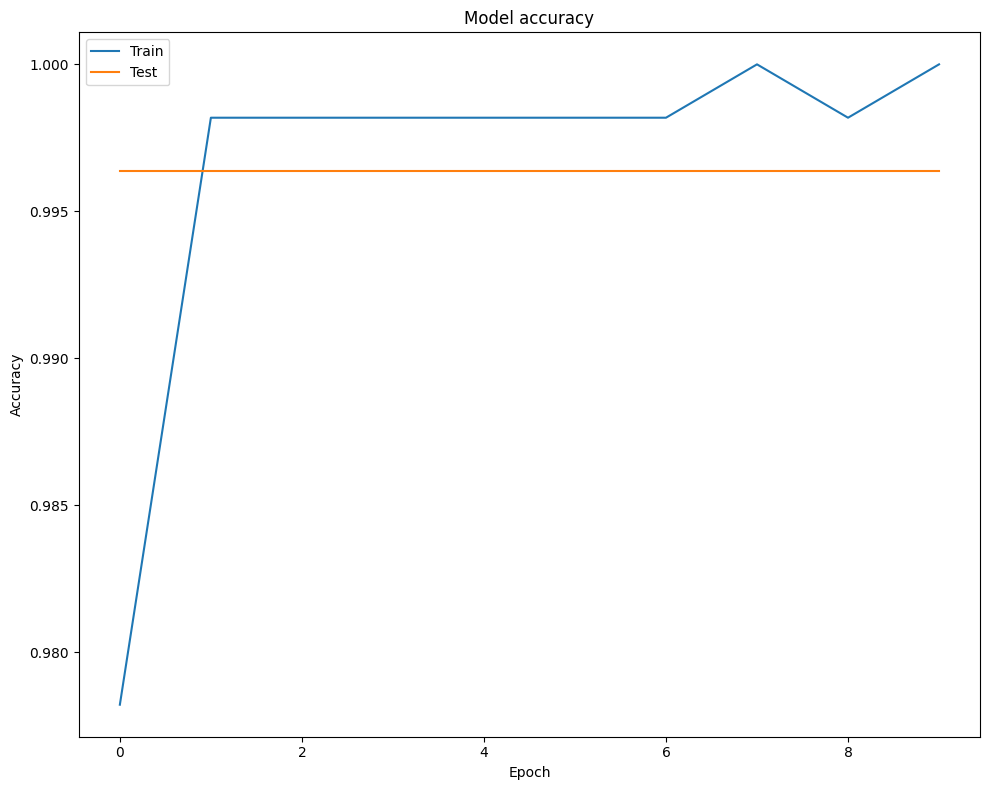

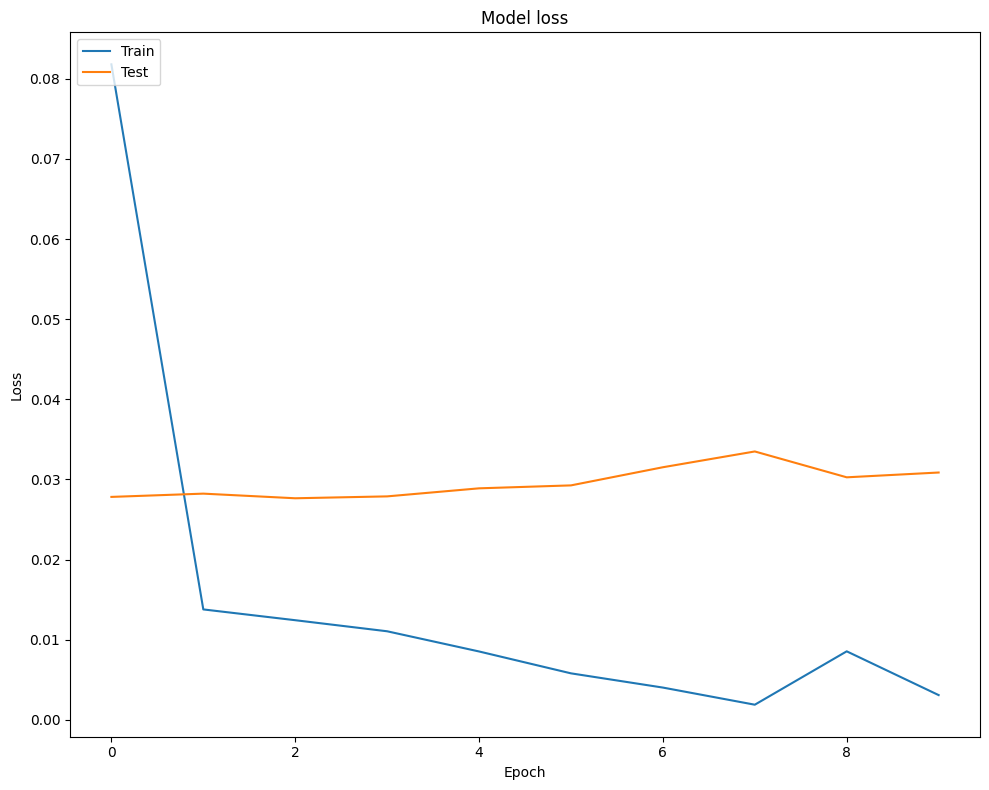

In [10]:
# Create the directories
os.makedirs('images/Recurrent Neural Network (RNN)', exist_ok=True)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/accuracy.png', dpi=600)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/loss.png', dpi=600)
plt.show()

In [11]:
# Create a new directory
os.makedirs('Models', exist_ok=True)

# Save the model
model_rnn.save('Models/Recurrent Neural Network (RNN).h5')

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Load the model
loaded_model = load_model('Models/Recurrent Neural Network (RNN).h5')

9/9 [==============================] - 1s 49ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.00      0.00         1

    accuracy                           1.00       276
   macro avg       1.00      0.50      0.50       276
weighted avg       1.00      1.00      0.99       276

ROC AUC: 0.5


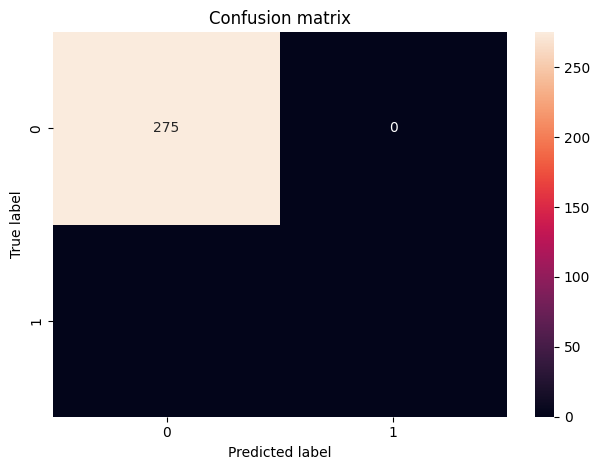

In [13]:
# X_test is the test data and y_test are the true labels
y_pred = loaded_model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary outputs

# Print the classification report
print(classification_report(y_test, y_pred, zero_division=1))

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/confusion_matrix.png', dpi=600)
plt.show()

In [14]:
# Create an array of IDs
ids = df['id'].values

# Split the IDs into training and test sets
_, ids_test = train_test_split(ids, test_size=0.2, random_state=42)

# Generate predictions
predictions = loaded_model.predict(X_test)

# If predictions is not a 1D array, flatten it
if predictions.ndim != 1:
    predictions = predictions.flatten()

# Create a new DataFrame with IDs and predictions
result_df = pd.DataFrame({
    'id': ids_test,
    'predictions': predictions
})

# Define the directory and file paths
dir_path = 'Data/submission'
file_path = os.path.join(dir_path, 'submission.csv')

# Create the directory if it doesn't exist
os.makedirs(dir_path, exist_ok=True)

# Save the DataFrame to a CSV file in the specified directory
result_df.to_csv(file_path, index=False)

9/9 [==============================] - 1s 54ms/step


In [15]:

submission_df = pd.read_csv('Data/submission/submission.csv')

# Display the data
submission_df

,id,predictions
0,70d7c567,0.000218
1,81977e6c,0.000181
2,e43869b8,0.000091
3,d33eca96,0.000215
4,71f7131e,0.000388
...,...,...
271,62b480e1,0.000215
272,7405b110,0.000214
273,47e743a7,0.000297
274,95d41c3e,0.000155
